In [19]:
import matplotlib as plt
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from google.cloud import bigquery

In [20]:
client = bigquery.Client(location="US", project="wf-gcp-us-ae-gat-prod")

In [21]:
query = """
SELECT
  DATE_TRUNC(time, DAY) AS ds,
  AVG(period_slot_s) AS y
FROM `wf-gcp-us-ae-general-prod.csn_analytic_product.tbl_bigquery_slots_aggregate`
WHERE 
  reservation_id IN ("wf-gcp-us-ae-reservation-prod:US.ae-gat")
GROUP BY 1
ORDER BY 1 ASC;
"""
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query

slot_actuals_df = query_job.to_dataframe()

In [22]:
slot_actuals_df["ds"] = slot_actuals_df.ds.astype("datetime64[ns]")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Using .astype to convert from timezone-aware dtype to timezone-naive dtype is deprecated and will raise in a future version.  Use obj.tz_localize(None) or obj.tz_convert('UTC').tz_localize(None) instead
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='ds'>

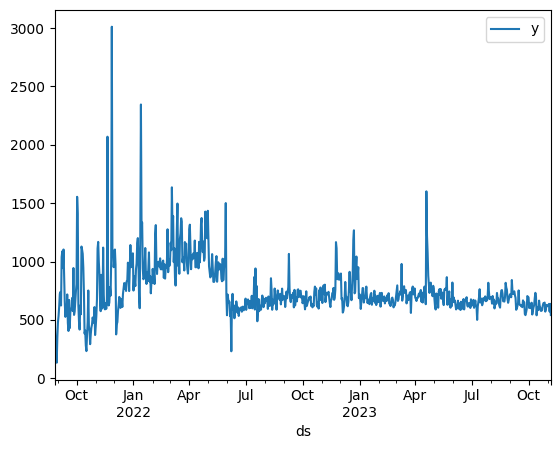

In [23]:
slot_actuals_df.plot("ds", "y")

# Modeling major promotion events

In [24]:
# major promotion event
cyber5 = pd.DataFrame(
    {
        "holiday": "Cyber5",
        "ds": pd.to_datetime(
            [
                "2021-11-26",
                "2021-11-27",
                "2021-11-28",
                "2021-11-29",
                "2022-11-25",
                "2022-11-26",
                "2022-11-27",
                "2022-11-28",
                "2023-11-24", ##UPDATE LATEST BLACK FRIDAY DATES
            ]
        ),
    }
)

wayday = pd.DataFrame(
    {
        "holiday": "WayDay",
        "ds": pd.to_datetime(["2022-04-27", "2022-04-28", "2022-10-26", "2022-10-27","2023-10-25","2023-10-26"]), #UPDATE WAYDAY DATES
    }
)

holidays = pd.concat((cyber5, wayday))
holidays

,holiday,ds
0,Cyber5,2021-11-26
1,Cyber5,2021-11-27
2,Cyber5,2021-11-28
3,Cyber5,2021-11-29
4,Cyber5,2022-11-25
5,Cyber5,2022-11-26
6,Cyber5,2022-11-27
7,Cyber5,2022-11-28
8,Cyber5,2023-11-24
0,WayDay,2022-04-27


#### Hyper-parameter tuning using grid search

In [25]:
import itertools

param_grid = {
    "changepoint_prior_scale": [
        0.001,
        0.01,
        0.05,
        0.1,
        0.5,
    ],  # larger value increases trend flexibility --> overfitting
    "seasonality_prior_scale": [
        0.01,
        0.1,
        1.0,
        10.0,
    ],  # smaller value corresponds to a smaller magnitude of seasonality.
    "seasonality_mode": ["additive", "multiplicative"],
}

# Generate all combinations of parameters
all_params = [
    dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())
]


def hyper_param_tuning(all_params, df):
    mape = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params, holidays=holidays).fit(df)  # Fit model with given params
        df_cv = cross_validation(m, horizon="14 days", parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        mape.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mape

    return tuning_results, df_p, df_cv

In [26]:
tuning_results, df_p, df_cv = hyper_param_tuning(all_params, slot_actuals_df)

14:01:32 - cmdstanpy - INFO - Chain [1] start processing
14:01:32 - cmdstanpy - INFO - Chain [1] done processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Chain [1] start processing
14:01:33 - cmdstanpy - INFO - Ch

#### Train model using best hyper-parameters

In [27]:
best_params_df = (
    tuning_results[tuning_results.mape == tuning_results.mape.min()]
    .drop(columns="mape")
    .head(1)
)
best_params_dict = best_params_df.to_dict("records")[0]

In [28]:
prophet_model = Prophet(
    **best_params_dict,
    holidays=holidays,
    growth="linear",  # default, no saturating growth for forecasting slots
    interval_width=0.99
)

In [29]:
prophet_model.fit(slot_actuals_df)

14:04:29 - cmdstanpy - INFO - Chain [1] start processing
14:04:29 - cmdstanpy - INFO - Chain [1] done processing


#### Forecasting for next 21 days

Depending on when you run the forecast, make sure that the number of period is sufficient to cover the dates that you need

In [30]:
future = prophet_model.make_future_dataframe(periods=21, freq="D")

In [31]:
forecast = prophet_model.predict(future)

#### Visualizing forecast

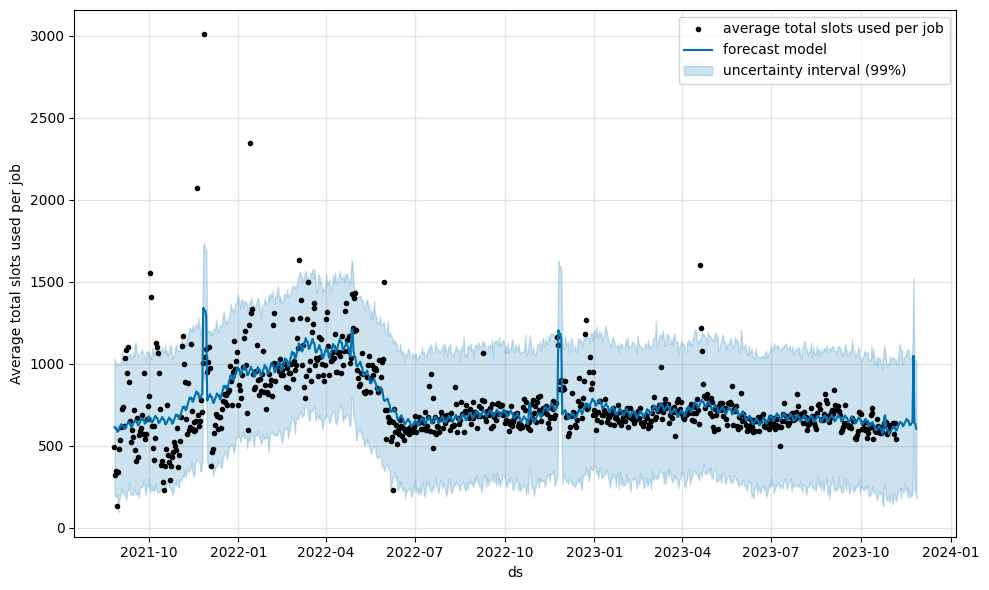

In [32]:
fig = prophet_model.plot(forecast)
ax = fig.gca()
ax.set_ylabel("Average total slots used per job")
ax.legend(
    [
        "average total slots used per job",
        "forecast model",
        "uncertainty interval (99%)",
    ],
    loc="upper right",
)

#### Time series decomposition

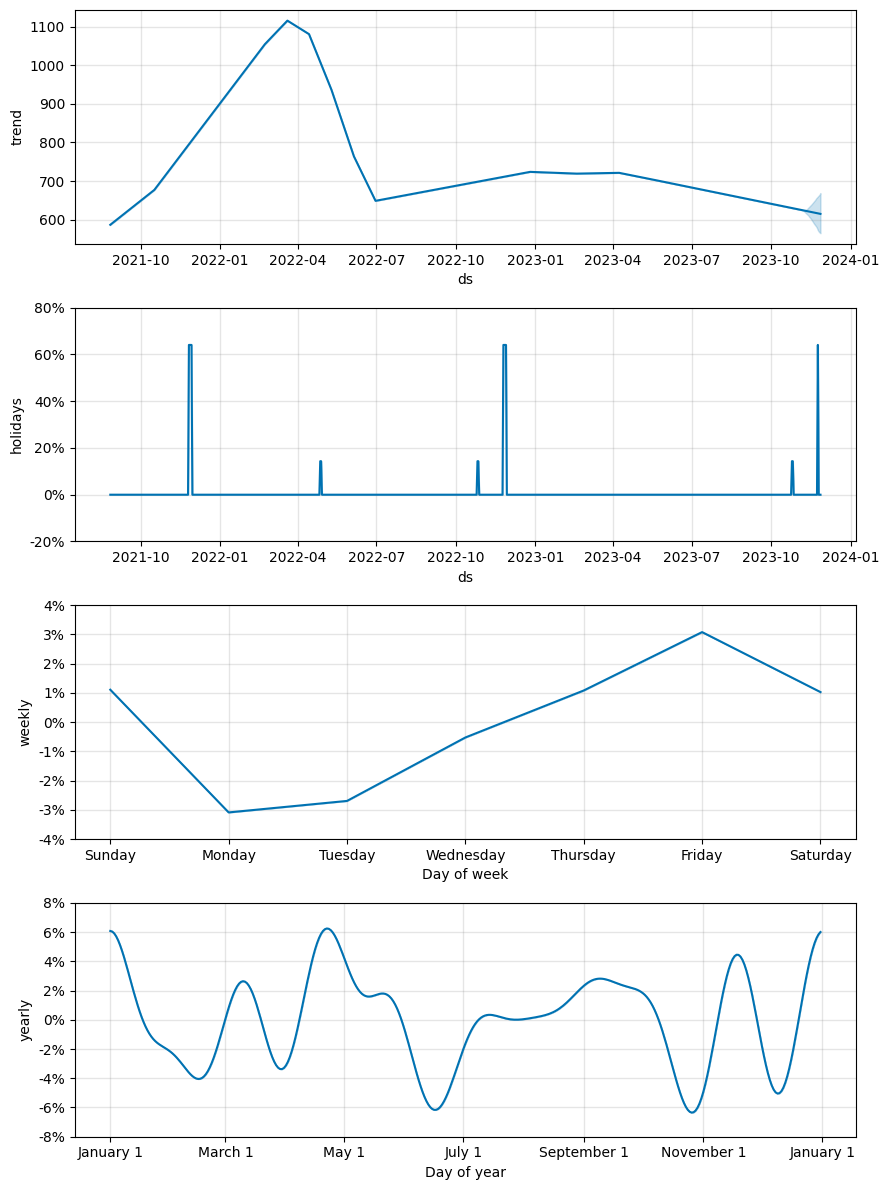

In [33]:
fig = prophet_model.plot_components(forecast)

#### Saving model as pickle

In [350]:
# Open a file and use dump()
import pickle

with open("daily_slot_prophet.pkl", "wb") as file:

    # A new file will be created
    pickle.dump(prophet_model, file)